# Introduction to the xgbsurv package - Efron

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import load_metabric
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


## Load Data

In [2]:
data = load_metabric(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

## Load Model

In [3]:
model = XGBSurv(n_estimators=25, objective="efron_objective",
                                             eval_metric="efron_loss",
                                             learning_rate=0.3,
                                             random_state=7, 
                                             disable_default_eval_metric=True)

The options of loss and objective functions can be obtained like below:

In [4]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [5]:
eval_set = [(X_train, y_train)]

In [6]:
model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-efron_likelihood:5290.77449
[1]	validation_0-efron_likelihood:5190.02979
[2]	validation_0-efron_likelihood:5104.36080
[3]	validation_0-efron_likelihood:5055.68260
[4]	validation_0-efron_likelihood:5011.06365
[5]	validation_0-efron_likelihood:4976.89885
[6]	validation_0-efron_likelihood:4946.76155
[7]	validation_0-efron_likelihood:4918.16449
[8]	validation_0-efron_likelihood:4896.63433
[9]	validation_0-efron_likelihood:4881.61130
[10]	validation_0-efron_likelihood:4845.67145
[11]	validation_0-efron_likelihood:4839.62542
[12]	validation_0-efron_likelihood:4822.74889
[13]	validation_0-efron_likelihood:4808.47302
[14]	validation_0-efron_likelihood:4799.50973
[15]	validation_0-efron_likelihood:4781.27562
[16]	validation_0-efron_likelihood:4759.62985
[17]	validation_0-efron_likelihood:4754.32861
[18]	validation_0-efron_likelihood:4739.48745
[19]	validation_0-efron_likelihood:4702.08783
[20]	validation_0-efron_likelihood:4683.02372
[21]	validation_0-efron_likelihood:4675.1626

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=True, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function efron_likelihood at 0x7fc6184611b0>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=25, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function efron_objective at 0x7fc6184616c0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [7]:
model.save_model("introduction_model_breslow.json")

## Predict

In [8]:
preds_train = model.predict(X_train, output_margin=True)
preds_test = model.predict(X_test, output_margin=True)

### Predict Cumulative Hazard

In [9]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards.head(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Predict Survival Function

In [10]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
287.933319,9.819653e-05,0.219142,3.793951e-07,0.189341,0.009902,3.080966e-06,1.525696e-20,0.015587,0.169184,0.000563,...,7.496212e-06,0.168538,0.213988,1.288776e-21,0.149557,0.048362,0.414707,0.006372,0.452822,0.057356
301.233337,2.594382e-06,0.120544,1.124448e-09,0.098326,0.001609,2.082937e-08,2.404119e-28,0.003028,0.084050,0.000030,...,7.192416e-08,0.083602,0.116611,7.674859e-30,0.070778,0.014674,0.293246,0.000870,0.331477,0.018612
335.733337,7.211609e-07,0.097653,1.446073e-10,0.078056,0.000848,3.581887e-09,4.284313e-31,0.001700,0.065689,0.000010,...,1.399202e-08,0.065304,0.094156,9.707377e-33,0.054378,0.009639,0.259539,0.000432,0.296976,0.012519


### Visualize Predictions

Text(0.5, 1.0, 'Survival Curve Test Set')

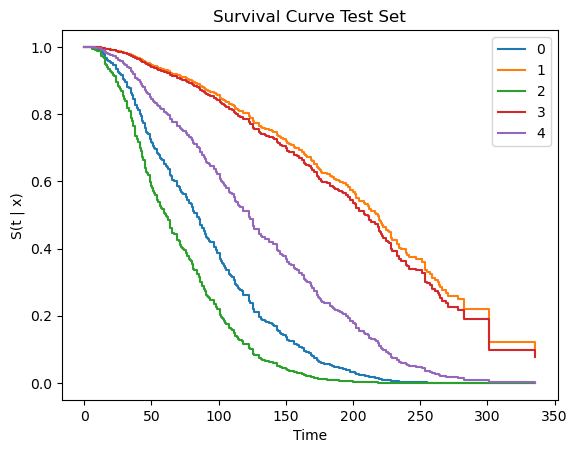

In [11]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

## Evaluate

In [12]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6182497905700246


In [13]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18840868814940412
